In [8]:
#imports
import skimage
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy 
import pandas as pd 
from skimage import filters
from skimage import feature 
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.segmentation import slic, mark_boundaries

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def bgSubRGB(bg, im, T):
    # TODO: consider normalizing brightness to avoid selecting shadows
    bgR = bg[:,:,0]
    bgG = bg[:,:,1]
    bgB = bg[:,:,2]
    
    imR = im[:,:,0]
    imG = im[:,:,1]
    imB = im[:,:,2]
    # Euclidean distance (slide 8 of region detection HW)
    return ((imR - bgR) ** 2 + (imG - bgG) ** 2 + (imB - bgB) ** 2) > T ** 2

In [3]:
def close(im):
    structure=np.ones((3,3))
    im = ndimage.binary_dilation(im, structure)
    im = ndimage.binary_erosion(im, structure)
    return im

In [4]:
def open(im):
    structure=np.ones((3,3))
    im = ndimage.binary_erosion(im, structure)
    im = ndimage.binary_dilation(im, structure)
    return im

0  regions in image  1


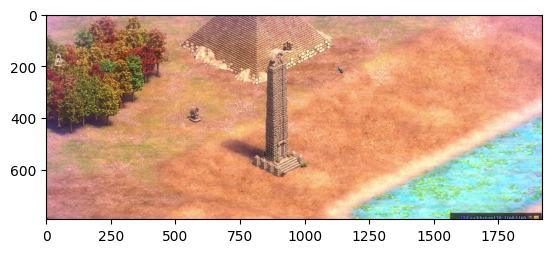

0  regions in image  2


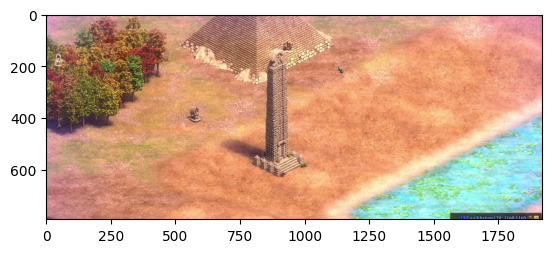

1  regions in image  3


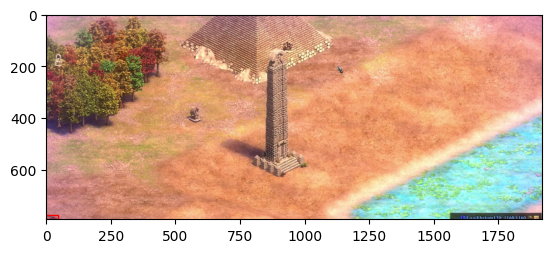

2  regions in image  4


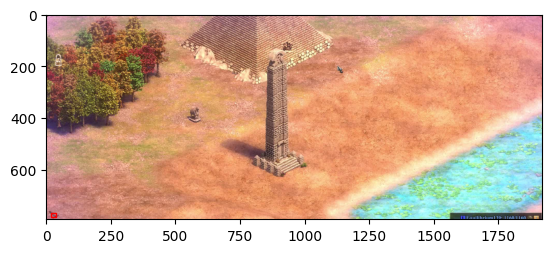

3  regions in image  5


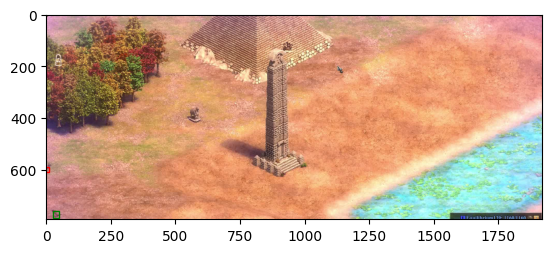

3  regions in image  6


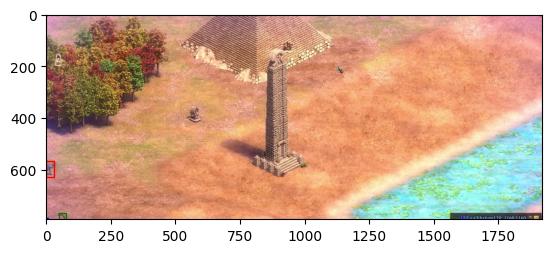

3  regions in image  7


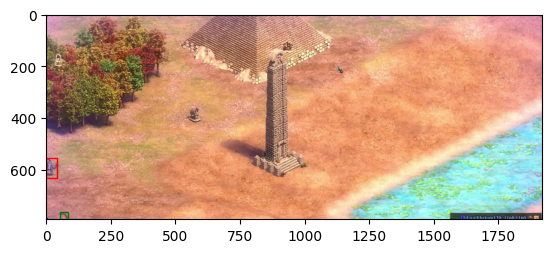

3  regions in image  8


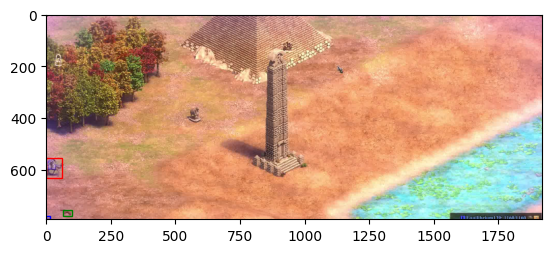

3  regions in image  9


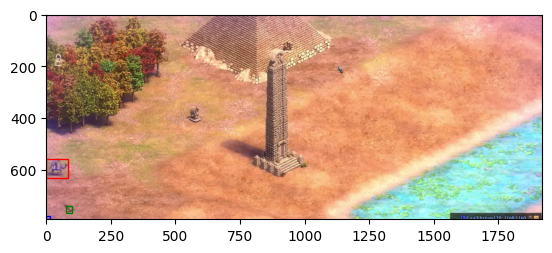

3  regions in image  10


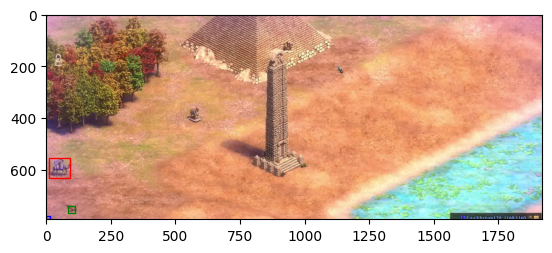

4  regions in image  11


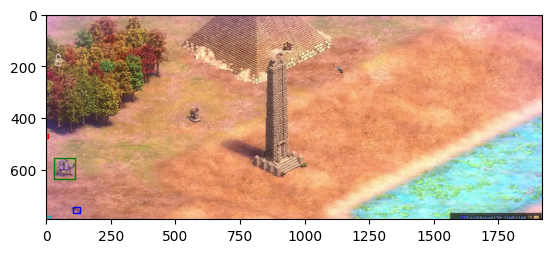

5  regions in image  12


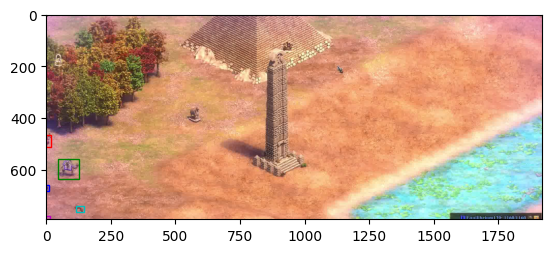

6  regions in image  13


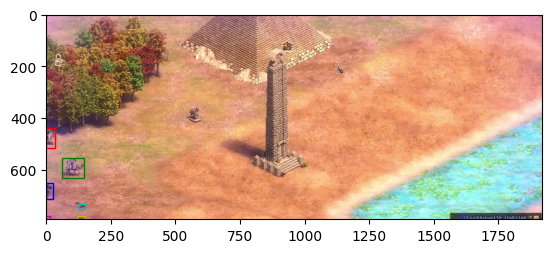

6  regions in image  14


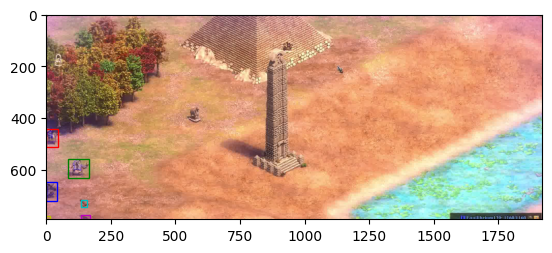

6  regions in image  15


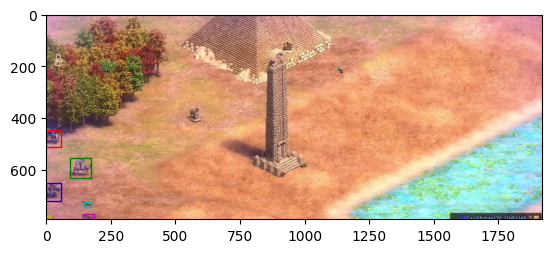

6  regions in image  16


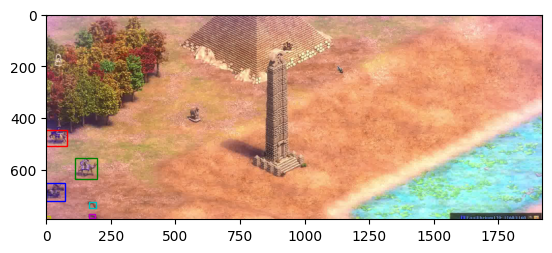

6  regions in image  17


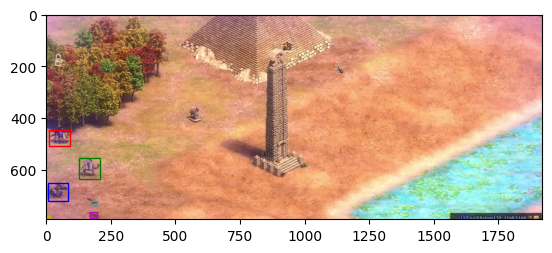

6  regions in image  18


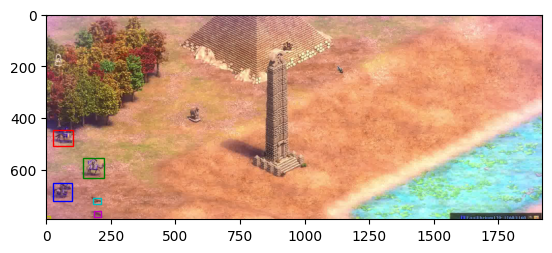

6  regions in image  19


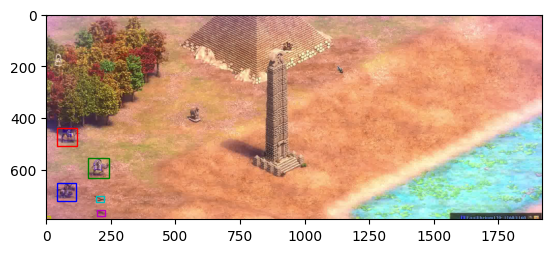

6  regions in image  20


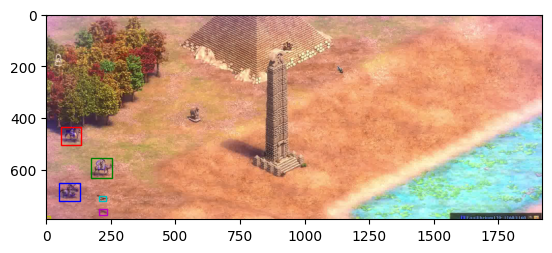

6  regions in image  21


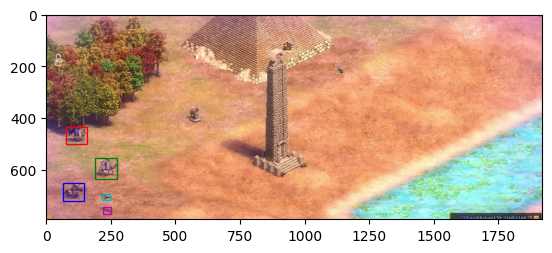

6  regions in image  22


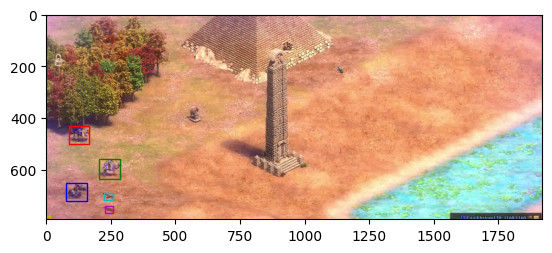

In [10]:
numFrames = 24
frames = np.array([io.imread('frames/frame (%d).jpg' % i) for i in range(1,numFrames)], dtype='float64')/255
T = 0.21
bg = frames[0]

#covariance models
models = np.zeros((6, 5, 5))
numModels = 0

colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i in range(1, len(frames)):
    diff = bgSubRGB(bg, frames[i], T)
    diff = open(diff)
    diff = skimage.filters.gaussian(diff, sigma=10)
    diff = diff > T
    labels = label(diff)
    regions = regionprops(labels)
    properties = regionprops_table(labels, diff, properties= \
                            ['bbox', 'area','convex_area','bbox_area'])
    print(len(regions), " regions in image ", i)
    outlines = mark_boundaries(frames[i], labels)
    
    
    covariances = np.zeros((6, 5, 5))
    locations = np.zeros((6, 4))
    props = pd.DataFrame(properties)
    for index, region in props.iterrows():
        x = region['bbox-1']
        y = region['bbox-0']
        window = frames[i][region['bbox-1']:region['bbox-3'],region['bbox-0']:region['bbox-2']]
        
        feature = np.zeros((5,window.shape[0]*window.shape[1]))
        for a in range(window.shape[0]):
            for b in range(window.shape[1]):
                feature[:, (a*window.shape[1] + b)] = np.array([a, b, window[a, b, 0], window[a, b, 1], window[a, b, 2]])
        
        cov = np.cov(feature, bias=True)
        locations[index] = [x, y, window.shape[0], window.shape[1]]
        covariances[index] = cov
        
    #assign each calculated covariance to a model
    regionsBool = np.zeros((6)) #regionsBool[i] = 1 if it needs to be 
    regionsBool[0:len(regions)] = 1 #assigned to a model for this frame
    minDist = 100000000
    orderedLocations = []
    for modelIndex in range(numModels):
        for index in range(len(regions)):
            if regionsBool[index] == 1:
                #calculate distances
                eigW, eigVal = sp.linalg.eig(models[modelIndex], covariances[index])
                dist =  np.sqrt((np.log(eigW)**2).sum())
                if dist < minDist:
                    minDist = dist
                    minIndex = index
                    
        #store data about winning region
        regionsBool[minIndex] = 0
        models[modelIndex] = covariances[minIndex]
        orderedLocations.append(locations[minIndex])
        
    #if we have a new region
    if len(regions) > numModels:
        for index in range(len(regions)):
            if regionsBool[index] == 1:
                models[numModels] = covariances[index]
    
    fig, ax = plt.subplots()
    ax.imshow(frames[i])
    for index in range(len(regions)):
        rect = patches.Rectangle((locations[index,0], locations[index,1]), locations[index,2], \
                                 locations[index,3], linewidth=1, edgecolor=colors[index], facecolor='none')
    
        ax.add_patch(rect)
    filename = 'outlines' + str(i) + '.jpg'
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
    #io.imsave(filename, (outlines*255).astype(np.uint8))